In [1]:
# load name samples
names = open("names.txt", 'r').read().splitlines()
chars = set(''.join(names))
print(len(chars))
print(names[:5])
print(len(names))

26
['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [2]:
chars = set()
for name in names:
    chars = chars | set(name)
chars = ['*'] + sorted(list(chars))
print(chars)

['*', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
ctoi = {char:i for i, char in enumerate(chars)}
itoc = {i:char for i, char in enumerate(chars)}
print(ctoi)

{'*': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In lession 1, one char was predicted per time based on bi-gram frequency probability. Now we consider more than 2 chars combination and set a block size that can be changed.

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

block_size = 3
X, Y = [], []
for name in names:
    context = [0] * block_size # should maintain sliding windows size of block_size
    for char in name + '*':
        idx = ctoi[char]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]
      

X_all = torch.tensor(X)
Y_all = torch.tensor(Y)

In [5]:
print(X_all.shape, X_all.dtype)
print(Y_all.shape, Y_all.dtype)

torch.Size([228146, 3]) torch.int64
torch.Size([228146]) torch.int64


In [6]:
def build_dataset(names):
    block_size = 3
    X, Y = [], []
    for name in names:
        context = [0] * block_size # should maintain sliding windows size of block_size
        for char in name + '*':
            idx = ctoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
import random
random.seed(42)
random.shuffle(names)
# 80% train data, 10% validation, 10% test
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))
Xtrain, Ytrain = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
num_samples = 32
X = X_all[:num_samples]
Y = Y_all[:num_samples]

In [9]:
# assume each char token maps to a two dimentional feature vector, then 27 chars are mapped to a 27 x 2 feature matrix
C = torch.randn((27, 2))
# X here serves is matrix indices to allocate feature vector in C
C[X].shape

torch.Size([32, 3, 2])

In [10]:
embeddings = C[X]
embeddings.shape

torch.Size([32, 3, 2])

In [11]:
embeddings = embeddings.view(-1, 6)
embeddings.shape

torch.Size([32, 6])

In [12]:
# initialize "encoder" neural network weight matrix, 6 x 100, meaning each input sample has 6 features and each feature has 100 connections
W1 = torch.randn((6, 100))
b1 = torch.randn((100)) # adding regularization bias values to each 100 connection weights

In [13]:
# hypothesis. 32 samples embeded feature matrix 32 x 6 is multiplicating neural network weight 6 x 100
# adding bias for regularization purpose
# pass through activations tanh 

h = torch.tanh(embeddings @ W1 + b1)
h.shape

torch.Size([32, 100])

In [14]:
# initialize "decoder" neural network weight and mapping to 27 char tokens
W2 = torch.randn((100, 27))
b2 = torch.randn(())

In [15]:
# matrix multiplication again using previous outputs in hypothesis
# now going for softmax and multinormial probability distribution to predict next token. Now has 27 probabilities per dataset sample
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [16]:
counts = logits.exp()

In [17]:
# normalize the distribution to range of 0 ~ 1.0
probs = counts / counts.sum(1, keepdim = True)
probs.shape

torch.Size([32, 27])

In [18]:
batch_size = 32

# calculate loss per batch using softmax formula
# use Y as index to allocate output probability

loss = -probs[torch.arange(batch_size), Y].log().mean()
loss

tensor(17.0541)

## Before Jumping to Train a Robust Name Generator, train a 2 feature embeddings model to boost confidence

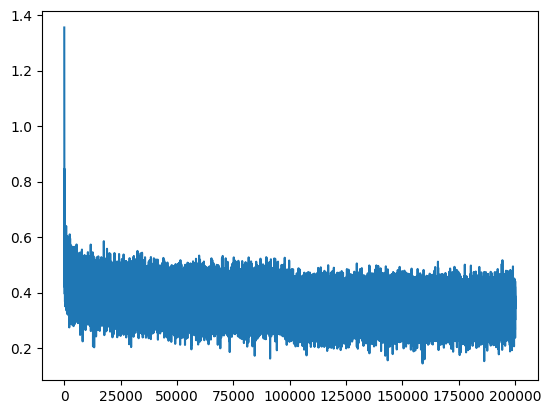

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# 27 char tokens, each char token maps to 2 features 
C = torch.randn((27, 2), generator=g)
# each char maps to 10 feature vector, and each input sample has 3 chars, so 30 features per input sample, giving 200 nodes per feature layer
W1 = torch.randn((6, 200), generator=g)
# 200 bias for each feature layer
b1 = torch.randn(200, generator=g)
# decoding back to 27 chars probabilities
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre


for p in parameters:
    p.requires_grad = True

loss_i = []
step_i = []

for i in range(200000):
  
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    
    # forward pass
    emb = C[Xtrain[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytrain[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    step_i.append(i)
    loss_i.append(loss.log10().item())

# plot decreasing loss over training iterations
plt.plot(step_i, loss_i)


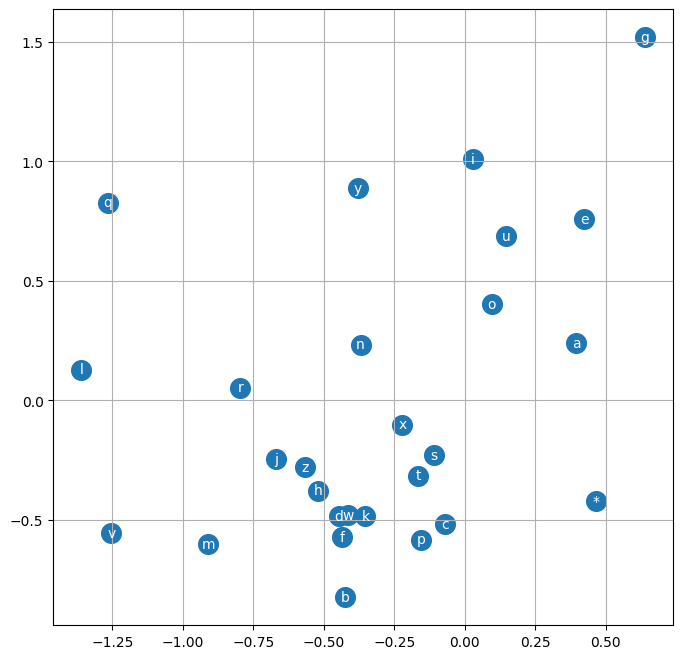

In [24]:
# Using 2 feature embeddings will cluster a,e,i,o,u, 10 features won't tell unless perform PCA to down dimension the 10 features to 2

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')


## Train a More Complex NN Model

In [25]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# 27 char tokens, each char token maps to 10 features vector instead of 2 now
C = torch.randn((27, 10), generator=g)
# each char maps to 10 feature vector, and each input sample has 3 chars, so 30 features per input sample, giving 200 nodes per feature layer
W1 = torch.randn((30, 200), generator=g)
# 200 bias for each feature layer
b1 = torch.randn(200, generator=g)
# decoding back to 27 chars probabilities
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre


for p in parameters:
    p.requires_grad = True

In [27]:
lri = []
lossi = []
stepi = []

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (32,))
  
  # forward pass
  emb = C[Xtrain[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytrain[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

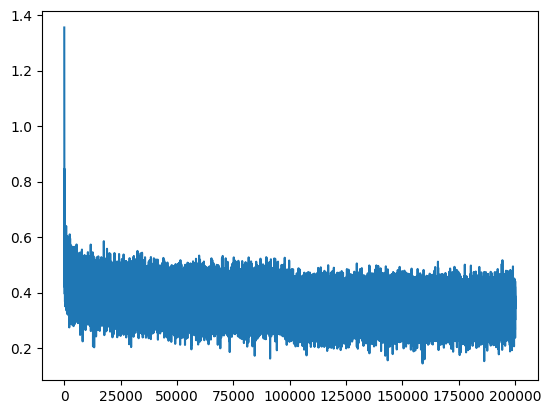

In [28]:
# plot decreasing loss over training iterations
plt.plot(step_i, loss_i)

In [29]:
# train loss
emb = C[Xtrain] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.1305, grad_fn=<NllLossBackward0>)

In [30]:
# test loss
emb = C[Xtest] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1710, grad_fn=<NllLossBackward0>)

In [42]:
# Write a name predictor

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)


block_size = 3

num_predictions = 10

for _ in range(num_predictions):
    name = ""
    context = [0] * block_size
    count = 0
    while True:
        embeddings = C[torch.tensor([context])] # [1, 3, 10]
    
        h = torch.tanh(embeddings.view(1, 30) @ W1 + b1) # (1, 200)
       
        logits = h @ W2 + b2 # (1, 27)
        
        probs = torch.softmax(logits, dim=1)

        # select next token index based on multinomial distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()


        if ix == 0:
            # end of the name generation
            break
        # shift context window
        context = context[1:] + [ix]
        char = itoc[ix]
        if count == 0:
            char = char.upper()
        name += char
        count += 1
        
    
    print(name)

Carpavela
Jhari
Kimlyn
Thty
Skanden
Jazhnen
Den
Rhe
Kaqui
Ner
